In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt, shap, pandas as pd, numpy as np, tensorflow as tf

In [4]:
shap.initjs()
pd.set_option('display.max_columns', None)

In [5]:
#df = pd.read_feather('E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/merged-full-25ms-24hr-28-2-24.feather')
#df = pd.read_feather('E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-25ms-24hr-11-3-24.feather')
#df = pd.read_feather('D:\Skóli\lokaverkefni_vel\data\merged-full-W-Landscape-And-Station-Elevations-25ms-24hr-11-3-24.feather')
#df = pd.read_feather('E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-25ms-24hr-13-3-24-stripped-with-klst.feather')
#df = pd.read_feather("E:/Skóli/HÍ/Vélaverkfræði Master Hí/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-Circle-larger-x2-25ms-24hr-14-3-24.feather")
#df = pd.read_feather("E:/Skóli/HÍ/Vélaverkfræði Master Hí/Lokaverkefni/Data/merged-full-W-Landscape-And-Station-Elevations-2-sectors-25ms-24hr-18-3-24-stripped-with-klst.feather")

df = pd.read_feather('D:/Skóli/lokaverkefni_vel/data/merged-full-W-Landscape-And-Station-Elevations-2-sectors-25ms-24hr-18-3-24-stripped-with-klst.feather')

df = df[df.f < df.fg]
df['gust_factor'] = df.fg / df.f

df_unfolded = df.elevations.apply(pd.Series)

df = pd.concat([df, df_unfolded], axis = 1)

df = df.dropna()
df = df.reset_index(drop = True)

In [6]:
n_elevations = df.columns[-1] + 1
df.iloc[:, -n_elevations:] = df.iloc[:, -n_elevations:].sub(df.station_elevation, axis = 0)

In [7]:
from sklearn.decomposition import PCA

df_landscape_elevation = df.iloc[:, -n_elevations:]

df_landscape_elevation = (df_landscape_elevation - df_landscape_elevation.mean()) / df_landscape_elevation.std()

n_components = 10

pca = PCA(n_components=n_components)
compressed_features = pca.fit_transform(df_landscape_elevation)

compressed_df = pd.DataFrame(data = compressed_features, columns = ['PC' + str(i) for i in range(n_components)])

df  = pd.concat([df, compressed_df], axis = 1)

In [8]:
from math import sqrt, sin, cos, acos, pi

def cornerFromCenterLand(row):
    X, Y, d = row.X, row.Y, row.d
    inlandX, inlandY = 520000, 485000

    len_v1 = sqrt((X-inlandX)**2 + (Y-inlandY)**2)

    v1 = ((X - inlandX)/len_v1, (Y - inlandY)/ len_v1)

    outX, outY = X + cos(d * pi / 180), Y + sin(d * pi / 180)

    len_v2 = sqrt(outX**2 + outY**2)

    v2 = (outX / len_v2, outY / len_v2)

    return acos(np.dot(v1, v2))
    

In [9]:
df['relativeCorner'] = df.apply(cornerFromCenterLand, axis = 1)

In [11]:
y = df.gust_factor
X = df[['Ri_01', 'Ri_12', 'N_01', 'N_12', 'station_elevation', 'relativeCorner'] + ['PC' + str(i) for i in range(n_components)]]

columns = X.columns

X, y = X.values.astype(np.float32), y.values.astype(np.float32)

scaler = StandardScaler()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)


train = pd.DataFrame(X_train, columns = columns)
train['gust_factor'] = y_train

validate = pd.DataFrame(X_val, columns = columns)
validate['gust_factor'] = y_val

test = pd.DataFrame(X_test, columns = columns)
test['gust_factor'] = y_test

In [12]:
X_shapley = pd.DataFrame(X, columns = columns)

X_shapley

,Ri_01,Ri_12,N_01,N_12,station_elevation,relativeCorner,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-1.177507,26685.779297,-0.000009,6.778615e-05,33.438522,2.732754,22.463312,2.761149,-0.885678,-2.739184,0.804405,-0.492156,0.492948,0.678533,0.018758,-0.076266
1,-2.864259,233.822189,-0.000038,1.961899e-06,33.438522,2.732754,22.638090,3.057970,-0.753052,-2.713240,0.850449,-0.560232,0.503225,0.474836,0.019441,-0.167719
2,-0.329725,0.959123,-0.000027,4.492563e-07,33.438522,2.732755,22.545942,3.751601,-0.369128,-2.014236,0.649158,-0.364212,0.255247,-0.641806,-0.196707,-0.894512
3,-0.551073,2.586584,-0.000055,3.586924e-06,33.438522,2.732754,22.709574,3.340035,-0.576344,-2.516097,0.798413,-0.538054,0.448227,0.165771,-0.066028,-0.402392
4,-0.261465,19.309135,-0.000028,3.372585e-05,33.438522,2.732754,22.662458,3.192364,-0.670980,-2.618812,0.841578,-0.605667,0.430852,0.379914,-0.044044,-0.291798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,-7.538465,4.194781,-0.000111,1.638547e-05,19.654911,0.554137,1.584966,0.067799,-0.005859,0.065996,0.002717,-0.042229,-0.079884,-0.014979,0.004299,-0.002414
10353,-0.042580,1.078334,-0.000026,8.712778e-05,19.654911,0.554136,1.584966,0.067799,-0.005859,0.065996,0.002717,-0.042229,-0.079884,-0.014979,0.004299,-0.002414
10354,-0.110178,12.661773,-0.000023,4.060586e-05,19.654911,0.554137,1.584966,0.067799,-0.005859,0.065996,0.002717,-0.042229,-0.079884,-0.014979,0.004299,-0.002414
10355,-0.264139,1.104732,-0.000128,2.704246e-05,19.654911,0.554136,1.584966,0.067799,-0.005859,0.065996,0.002717,-0.042229,-0.079884,-0.014979,0.004299,-0.002414


In [13]:
from tensorflow.keras.regularizers import l2

n_units = 256
n_epochs = 500
batch_size = 128
penalty = 0.1

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty), input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(units=n_units, activation='relu', kernel_regularizer=l2(penalty)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(units=1, activation='linear')
])

In [ ]:
import shap

background_data = shap.maskers.Independent(X_shapley)

explainer = shap.Explainer(model.predict, background_data)

#shap_values = explainer.shap_values(X_shapley[:100])

shap_values = explainer(X_shapley[:1000])

In [21]:
from matplotlib import pyplot as plt

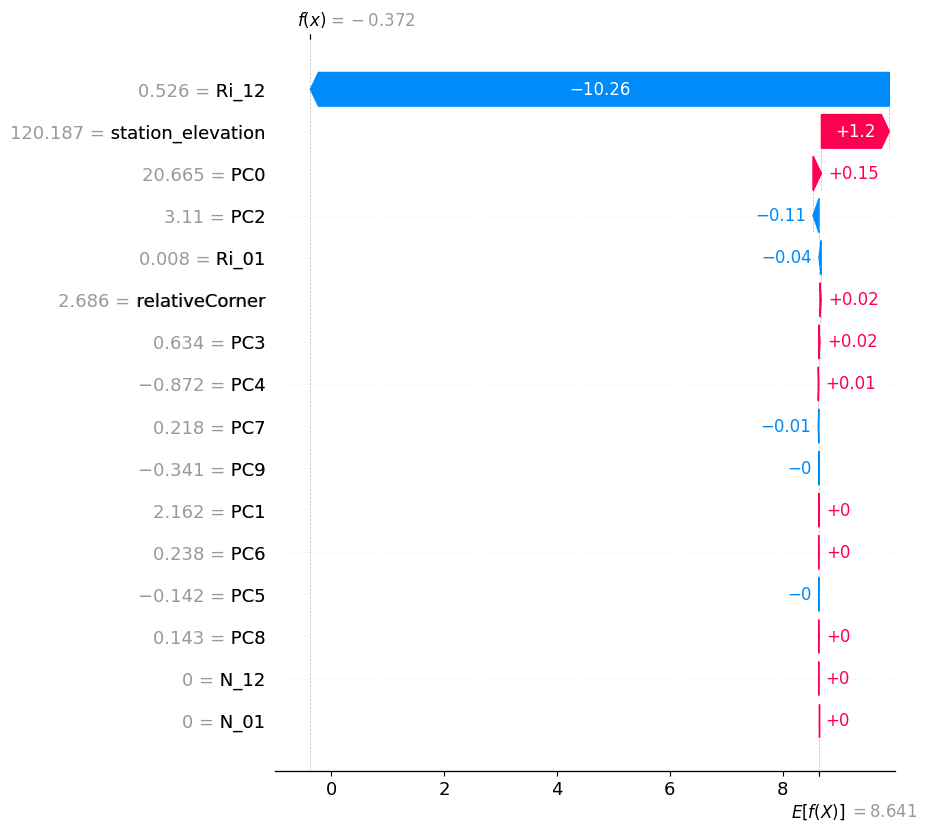

In [25]:
shap.plots.waterfall(shap_values[100], max_display=50, show = False)

plt.savefig("../../visualization/shap_waterfall_nn_256_example100.png", bbox_inches = 'tight', dpi = 1000)

plt.show()


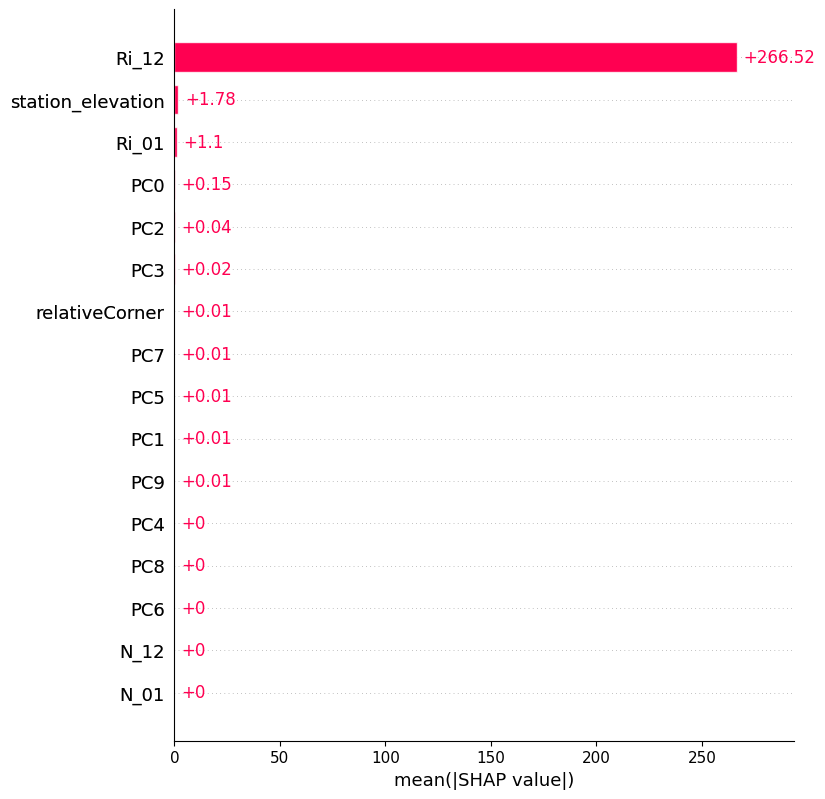

In [26]:
shap.plots.bar(shap_values, max_display=20, show=False)

plt.savefig("../../visualization/shap_bar_nn_256_example100.png", bbox_inches = 'tight', dpi = 1000)

plt.show()